In [1]:
import os
import yaml
import pickle
import matplotlib
from multiprocessing import Pool

import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.ticker as ticker
import torchvision
from scipy import stats
import matplotlib.pyplot as plt
import bilby
from tqdm.notebook import tqdm_notebook
from chainconsumer import ChainConsumer
from matplotlib import gridspec
import scipy
from PIL import Image
import torch
import seaborn as sns
from ipywidgets import *
import pandas as pd


matplotlib.use('pdf')
os.environ['MPLCONFIGDIR'] = '/home/local/nihargupte'
import dingo.gw.dataset.generate_dataset 
from dingo.gw.inference import injection
import dingo.gw.training.train_builders
import dingo.gw.waveform_generator
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
import dingo.gw.dataset
from dingo.gw.domains import build_domain
import dingo.gw.inference
from dingo.gw.transforms import SelectStandardizeRepackageParameters, RepackageStrainsAndASDS, UnpackDict, SampleExtrinsicParameters, GNPECoalescenceTimes, AddWhiteNoiseComplex
from dingo.core.models import PosteriorModel
import dingo.gw.domains
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-k6w6rfjw because the default path (/home/nihargupte/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


interactive(children=(FloatSlider(value=1.0, description='Parameter A', max=1.0), FloatSlider(value=0.0, descr…

<function __main__.update(w, d=0.0)>

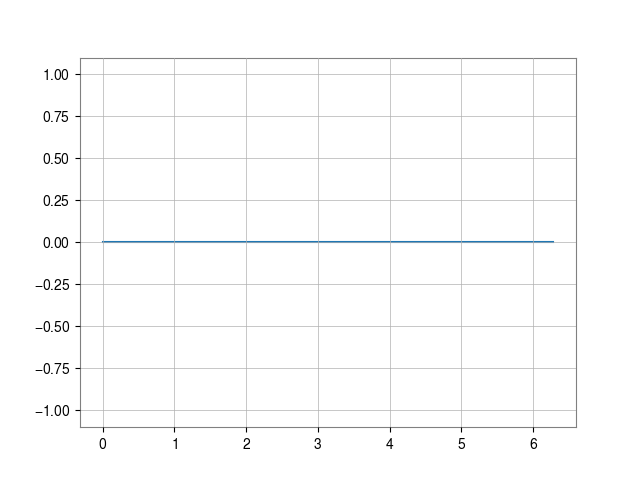

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w, d = 0.0):
    line.set_ydata(d * np.sin(w * x))
    fig.canvas.draw_idle()

interact(update, w=FloatSlider(min=0, max=1, step=0.1, value=1.0, description='Parameter A'))

In [2]:
models_dir = "/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin"
waveform_generation_dir = '/home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/waveforms'

seob_device, imrp_device = 3, 3
# build posterior model
torch.cuda.set_device(seob_device)
seob_main_pm = PosteriorModel(
    device="cuda",
    **{"model_filename": f"{models_dir}/train_dir_SEOBNRv4HM_ROM_O1_1024/model_latest.pt"},
)

seob_time_pm = PosteriorModel(
    device='cuda',
    **{"model_filename": f"{models_dir}/train_dir_SEOBNRv4HM_ROM_O1_1024_time/model_latest.pt"}
)

Putting posterior model to device cuda.
Putting posterior model to device cuda.


In [3]:
os.environ["LAL_DATA_PATH"] = "/home/local/nihargupte/dingo-devel/venv/lib/python3.9/site-packages/lalsimulation/"
# Have to stay in priors
# also check mass with the scatter plot as well
injection_generator = injection.Injection.from_posterior_model(seob_main_pm)
asd_dataset = ASDDataset(
    file_name=seob_main_pm.metadata["train_settings"]["training"]["stage_0"][
        "asd_dataset_path"
    ]
)
asd = asd_dataset.sample_random_asds()
injection_generator.asd = asd


Loading dataset from /home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/ASDs_new/1024_1/asds_O1.hdf5.


In [29]:
injection_generator = injection.Injection.from_posterior_model(seob_main_pm)
init_sampler = GWSampler(model=seob_time_pm)
sampler = GWSamplerGNPE(model=seob_main_pm, init_sampler=init_sampler, num_iterations=10)

GNPE parameters:  ['H1_time', 'L1_time']


In [27]:
charizard_hex = ('#cd5241', '#084152', '#eede7b', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118')
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

In [26]:
N = 1
def update(
    mass_ratio,
    chirp_mass,
    chi_1,
    chi_2,
    phase,
    theta_jn,
    psi,
    ra,
    dec,
    geocent_time,
    luminosity_distance,
    vars,
):

    vars.injection_generator
    theta = {
        "mass_ratio": mass_ratio,
        "chirp_mass": chirp_mass,
        "chi_1": chi_1,
        "chi_2": chi_2,
        "phase": phase,
        "theta_jn": theta_jn,
        "psi": psi,
        "ra": ra,
        "dec": dec,
        "geocent_time": geocent_time,
        "luminosity_distance": luminosity_distance,
    }
    strain_data = injection_generator.injection(theta)

    # Plotting Data
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    [axes[i].grid(True) for i in range(axes.shape[0])]
    strain_data_no_noise = injection_generator.signal(theta)
    axes[0].set_xlim([20, 1024])
    axes[0].set_ylim([1e-26, 1e-18])
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].plot(vars.sampler.domain.sample_frequencies, np.abs(strain_data["waveform"]["H1"]), color=vars.charizard_hex[0])
    axes[0].plot(vars.sampler.domain.sample_frequencies, np.abs(strain_data_no_noise["waveform"]["H1"]), color=vars.charizard_hex[1])

    axes[1].set_xlim([20, 1024])
    axes[1].set_ylim([1e-26, 1e-18])
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].plot(vars.sampler.domain.sample_frequencies, injection_generator.asd["H1"], color=vars.charizard_hex[2])

    sampler.context = strain_data
    sampler.run_sampler(
        num_samples=10_000,
        batch_size=10_000,
    )
    c = ChainConsumer()
    c.add_chain(sampler.samples, color=charizard_hex[0], name='dingo')
    c.configure(
        linestyles=["-"] * N,
        linewidths=[1.5] * N,
        sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, 0.9]],
        shade=[False] + [True] * (N - 1),
        shade_alpha=0.3,
        bar_shade=False,
        label_font_size=10,
        tick_font_size=10,
        usetex=False,
        legend_kwargs={"fontsize": 30},
        kde=0.7
    )

    fig = c.plotter.plot(truth=theta)

asd_dataset = ASDDataset(
    file_name=seob_main_pm.metadata["train_settings"]["training"]["stage_0"][
        "asd_dataset_path"
    ]
)
asd = asd_dataset.sample_random_asds()
injection_generator.asd = asd

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


vars = {
    "charizard_hex": charizard_hex,
    "injection_generator": injection_generator,
    "sampler": sampler,
}
vars = AttrDict(vars)
kwargs = {
    k: BoundedFloatText(min=v.minimum, max=v.maximum, value=(v.minimum + v.maximum) / 2)
    for k, v in injection_generator.prior.items()
}
interact(update, vars=fixed(vars), **kwargs)



Loading dataset from /home/local/nihargupte/dingo-devel/tutorials/03_aligned_spin/datasets/ASDs_new/1024_1/asds_O1.hdf5.


interactive(children=(BoundedFloatText(value=0.5625, description='mass_ratio', max=1.0, min=0.125), BoundedFlo…

<function __main__.update(mass_ratio, chirp_mass, chi_1, chi_2, phase, theta_jn, psi, ra, dec, geocent_time, luminosity_distance, vars)>